# Первоначальный анализ данных набора данных кредитного рейтинга

In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

## Загрузка данных

In [63]:
df=pd.read_csv("german_credit_risk.csv")
df=df.iloc[:,1:]
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


# Описание атрибутов

Age - Возраст (numeric) <br>
Sex	- Пол (text: male - мужской, female - женский) <br>
Job - Работа (numeric: 0 - неквалифицированный, 1 - неквалифицированный работник, нерезидент, 2 - квалифицированныйб резидент, 3 - высококвалифицированный) <br>
Housing - Жилье (text: собственное (own), арендованное (rent) или бесплатное (free)) <br>
Saving accounts - Статус накопительного (сберегательного) счета (text - маленький (little), средний, довольно богатый (quite rich), богатый (rich)) <br>
Checking account - Расчетный счет (text - little, NaN, moderate, rich) <br>
Credit amount - Сумма кредита (numeric, в немецких марках) <br>
Duration - Продолжительность (numeric, in month) <br>
Purpose - Цель кредита (text: машина, мебель/техника, радио / ТВ, бытовая техника, ремонт, образование, бизнес, отдых, отпуск /прочее <br>
Риск (целевое значение - хороший или плохой риск)<br>

### Приведем имена столбцов к удобному имени

In [64]:
df = df.rename(columns=lambda x: x.lower().replace(" ", "_"))

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age               1000 non-null   int64 
 1   sex               1000 non-null   object
 2   job               1000 non-null   int64 
 3   housing           1000 non-null   object
 4   saving_accounts   817 non-null    object
 5   checking_account  606 non-null    object
 6   credit_amount     1000 non-null   int64 
 7   duration          1000 non-null   int64 
 8   purpose           1000 non-null   object
 9   risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


age, job, credit_amount, duration - количественные переменные, остальные - факторные (качественные). saving_accounts и checking_account имеют пропущенные значения

In [66]:
df.describe()

,age,job,credit_amount,duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


Данные по возрасту, работе, сумме кредита, дюрации вполне нормальные, аномалии отсутствуют и отрицательные значения тоже отсутствуют. Максимальный срок кредита вполне удовлетворяющий - 72 месяца или 6 лет, минимальный возраст заемщика - 19 лет и так далее.

## Корреляционная матрица для количественных факторов

In [67]:
df.corr()

,age,job,credit_amount,duration
age,1.000000,0.015673,0.032716,-0.036136
job,0.015673,1.000000,0.285385,0.210910
credit_amount,0.032716,0.285385,1.000000,0.624984
duration,-0.036136,0.210910,0.624984,1.000000


Дюрация кредита и сумма кредита имеют значимую положительную корреляцию, отличную от нуля, что ожидаемо

### Уникальные значения

In [68]:
print("Число уникальных значений:", df.nunique(), sep="\n")
print("-"*100, "Уникальная значения:", sep="\n")
for num in df.columns:
    if not num in ("credit_amount", "duration"):
        print(num, df[num].unique())

Число уникальных значений:
age                  53
sex                   2
job                   4
housing               3
saving_accounts       4
checking_account      3
credit_amount       921
duration             33
purpose               8
risk                  2
dtype: int64
----------------------------------------------------------------------------------------------------
Уникальная значения:
age [67 22 49 45 53 35 61 28 25 24 60 32 44 31 48 26 36 39 42 34 63 27 30 57
 33 37 58 23 29 52 50 46 51 41 40 66 47 56 54 20 21 38 70 65 74 68 43 55
 64 75 19 62 59]
sex ['male' 'female']
job [2 1 3 0]
housing ['own' 'free' 'rent']
saving_accounts [nan 'little' 'quite rich' 'rich' 'moderate']
checking_account ['little' 'moderate' nan 'rich']
purpose ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']
risk ['good' 'bad']


Уникальные значения соответствуют описанию

## Пропуски

In [69]:
def missing_value_table(df):
    missing_value = df.isna().sum().sort_values(ascending=False)
    missing_value_percent = 100 * df.isna().sum()//len(df)
    missing_value_table = pd.concat([missing_value, missing_value_percent], axis=1)
    missing_value_table_return = missing_value_table.rename(columns = {0 : 'missing_values', 1 : '%'})
    cm = sns.light_palette("lightgreen", as_cmap=True)
    missing_value_table_return = missing_value_table_return.style.background_gradient(cmap=cm)
    return missing_value_table_return
  
missing_value_table(df)

,missing_values,%
checking_account,394,39
saving_accounts,183,18
age,0,0
sex,0,0
job,0,0
housing,0,0
credit_amount,0,0
duration,0,0
purpose,0,0
risk,0,0


saving_accounts и checking_account имеют пропущенные значения, причем % довольно большой, особенно для checking_account

## Кросс таблицы

In [77]:
pd.crosstab(df["sex"],df["risk"], normalize=True)

risk,bad,good
sex,,
female,0.109,0.201
male,0.191,0.499


In [78]:
pd.crosstab(df["housing"],df["risk"], normalize=True)

risk,bad,good
housing,,
free,0.044,0.064
own,0.186,0.527
rent,0.070,0.109


Вывод: по кросс таблицам - риск не особо зависит от пола. Обладатели своего жилья чаще хорошие заемщики, чем остальные

## Сделаем anova тест для проверки нулевой гипотезы о равенстве средних credit_amount для групп purpose (то есть хотим проверить гипотезу о том, что в среднем сумма выданных кредитов распределена равномерно в зависимости от цели кредита)

In [84]:
df.head(2)

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad


In [92]:
from scipy import stats

df1 = df.copy()

df1 = df1[["credit_amount","purpose"]]

group = pd.unique(df1.purpose.values)

d_v1 = {grp:df1["credit_amount"][df1.purpose == grp] for grp in group}


In [93]:
f, p = stats.f_oneway(d_v1['radio/TV'],d_v1['furniture/equipment'],d_v1['car'],d_v1['business'],d_v1['domestic appliances'],d_v1['repairs'],
                     d_v1['vacation/others'],d_v1['education'])

("F statistics: "+str(f)+" | P value : "+str(p))

'F statistics: 13.34142171179633 | P value : 1.585947764999813e-16'

### H0: Значимых различий средних по группам нет.

### H1: По крайней мере, среднее значение одной группы отличается.

### P value < 0.05

### Результат: отклоняем нулевую гипотезу.

In [15]:
(df.groupby(by=["Purpose"])[["Credit amount"]].agg("sum") / df["Credit amount"].sum())*100

,Credit amount
Purpose,
business,12.329507
car,38.819347
domestic appliances,0.549513
education,5.192895
furniture/equipment,16.969771
radio/TV,21.292818
repairs,1.834707
vacation/others,3.011441


В результате между группами наблюдается различие.
В dataframe, полученным сверху, видна разница.

# Визуализация

Гистограммы для возраста, суммы кредиты, дюрации

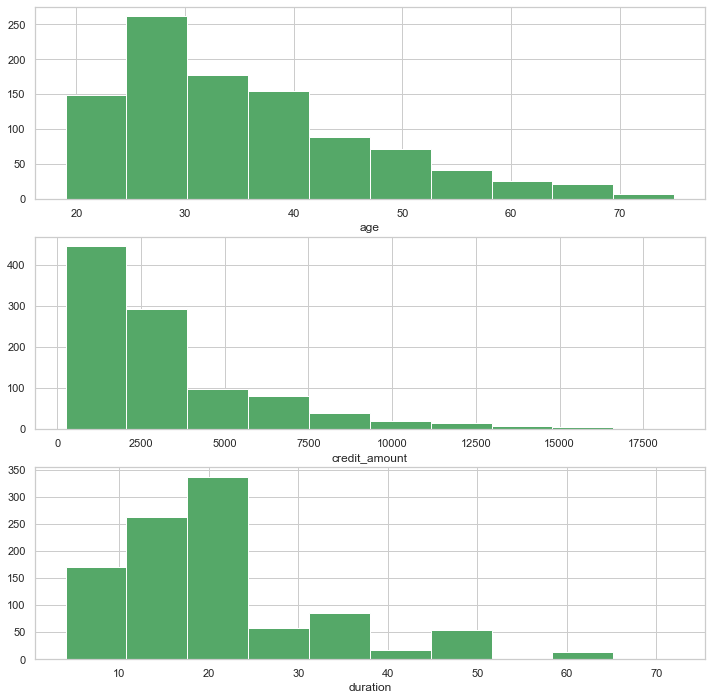

In [122]:
sns.set(font_scale=1,style="whitegrid")
fig,ax=plt.subplots(nrows=3,figsize=(12,12))
cat_list=["age","credit_amount","duration"]

for i in range(3):
    ax[i].hist(df[cat_list[i]], color="g")
    ax[i].set_xlabel(cat_list[i])

Добавим переменные месячый платеж и квадрат суммы кредита

In [124]:
df["monthly_pay"] = (df["credit_amount"] / df["duration"])
df["credit_amount^2"] = df["credit_amount"]**2

Разобьем дюрацию и возраст на промежутки для дальнейшей визуализации

In [125]:
df.insert(1,"gap_age",np.NaN)
df.loc[df["age"]<25,"gap_age"]="0-25"
df.loc[((df["age"]>=25) & (df["age"]<30)),"gap_age"]="25-30"
df.loc[((df["age"]>=30) & (df["age"]<35)),"gap_age"]="30-35"
df.loc[((df["age"]>=35) & (df["age"]<40)),"gap_age"]="35-40"
df.loc[((df["age"]>=40) & (df["age"]<50)),"gap_age"]="40-50"
df.loc[((df["age"]>=50) & (df["age"]<76)),"gap_age"]="50-75"

In [126]:
df.insert(9,"gap_duration",df["duration"])
for i in df["gap_duration"]:
    if i<12:
        df["gap_duration"]=df["gap_duration"].replace(i,"0-12")
    elif (i>=12) and (i<24):
        df["gap_duration"]=df["gap_duration"].replace(i,"12-24")
    elif (i>=24) and (i<36):
        df["gap_duration"]=df["gap_duration"].replace(i,"24-36")
    elif (i>=36) and (i<48):
        df["gap_duration"]=df["gap_duration"].replace(i,"36-48")
    elif (i>=48) and (i<60):
        df["gap_duration"]=df["gap_duration"].replace(i,"48-60")
    elif (i>=60) and (i<=72):
        df["gap_duration"]=df["gap_duration"].replace(i,"60-72")

In [127]:
df.insert(4,"type_job",df["job"])
df["type_job"]=df["type_job"].astype("category")
df["type_job"]=df["type_job"].replace(0,"unskilled")
df["type_job"]=df["type_job"].replace(1,"resident")
df["type_job"]=df["type_job"].replace(2,"skilled")
df["type_job"]=df["type_job"].replace(3,"highly skilled")

In [142]:
df["job"]=pd.Categorical(df["job"],categories=[0,1,2,3],ordered=True)
df["gap_age"]=pd.Categorical(df["gap_age"],categories=['0-25','25-30', '30-35','35-40','40-50','50-75'])
df["gap_duration"]=pd.Categorical(df["gap_duration"],categories=['0-12','12-24', '24-36','36-48','48-60','60-72'])

In [143]:
df.head()

,age,gap_age,sex,job,type_job,housing,saving_accounts,checking_account,credit_amount,duration,gap_duration,purpose,risk,monthly_pay,credit_amount^2
0,67,50-75,male,2,skilled,own,NaN,little,1169,6,0-12,radio/TV,good,194.833333,1366561
1,22,0-25,female,2,skilled,own,little,moderate,5951,48,48-60,radio/TV,bad,123.979167,35414401
2,49,40-50,male,1,resident,own,little,NaN,2096,12,12-24,education,good,174.666667,4393216
3,45,40-50,male,2,skilled,free,little,little,7882,42,36-48,furniture/equipment,good,187.666667,62125924
4,53,50-75,male,2,skilled,free,little,little,4870,24,24-36,car,bad,202.916667,23716900


### Диаграмма для риска

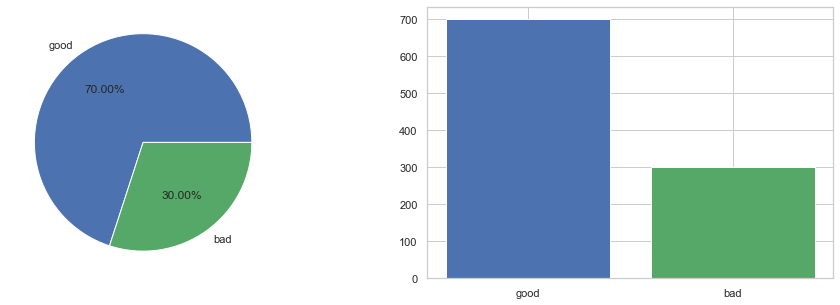

In [181]:
fig,ax=plt.subplots(ncols=2,figsize=(16,5))
ax[0].pie(df["risk"].value_counts(), labels=df["risk"].value_counts().index, autopct='%1.2f%%', colors = ["b", "g"])
ax[1].bar(df["risk"].value_counts().index, df["risk"].value_counts(), color = ["b", "g"])
plt.show()

## Распределение факторов заемщиков

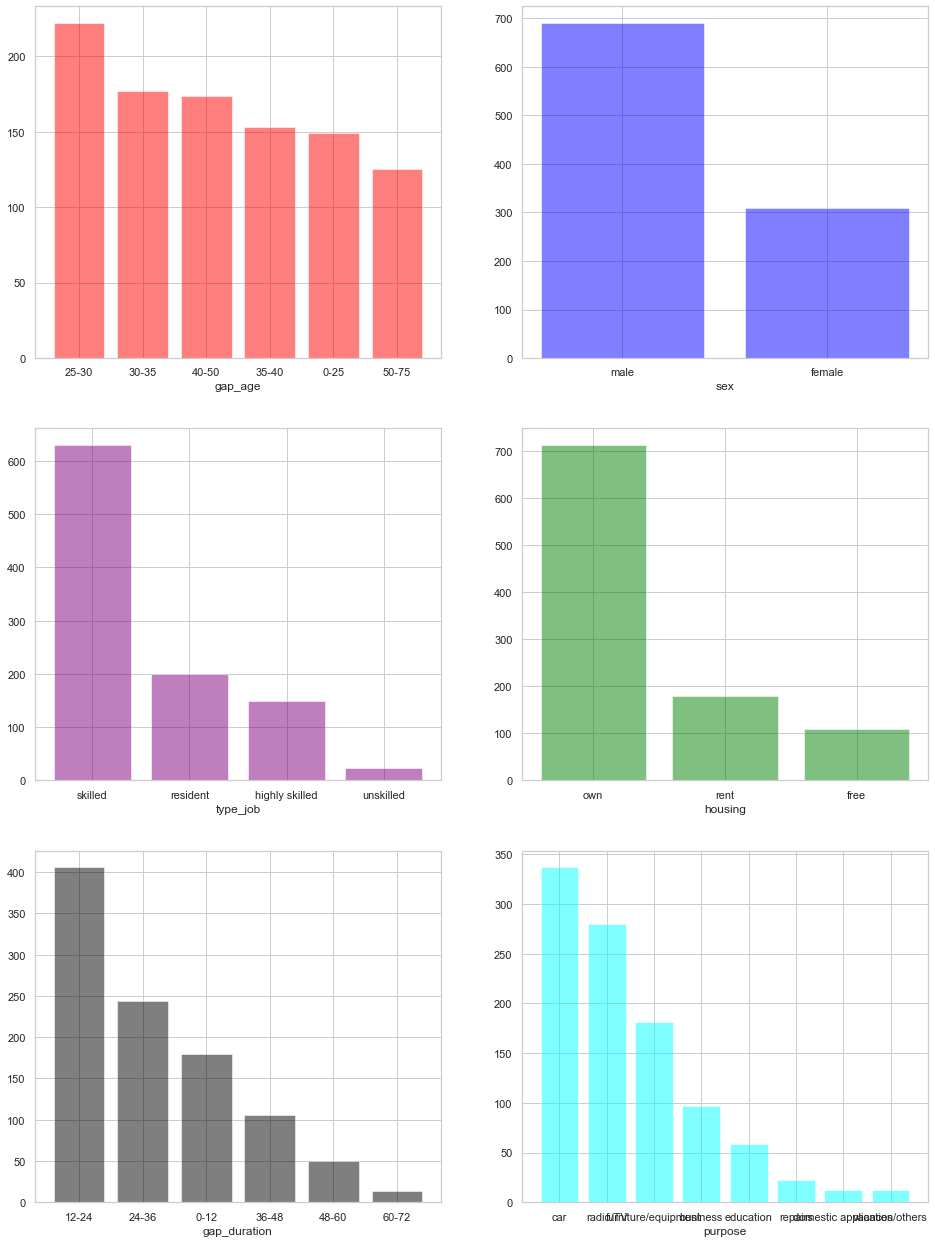

In [196]:
fig,ax=plt.subplots(ncols=2,nrows=3,figsize=(16,22))
cat_list=["gap_age","sex","type_job","housing","gap_duration","purpose"]
palette=["red","blue","purple","green","black","cyan"]
count=0
for i in range(3):
    for j in range(2):
        ax[i, j].bar(df[cat_list[count]].value_counts().index, df[cat_list[count]].value_counts(), color=palette[count], alpha=0.5)
        ax[i, j].set_xlabel(cat_list[count])
        count+=1

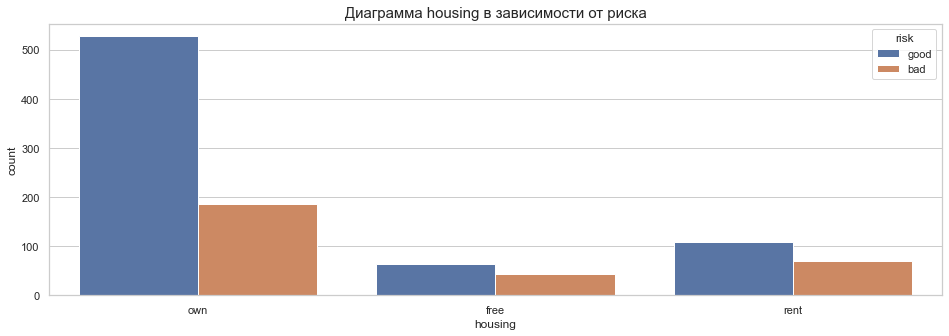

In [214]:
plt.figure(figsize=(16,5))
sns.countplot(x="housing", hue="risk", data=df).set_title("Диаграмма housing в зависимости от риска", fontsize=15);
plt.show()

Заемщики с собственным жильем - надежнее

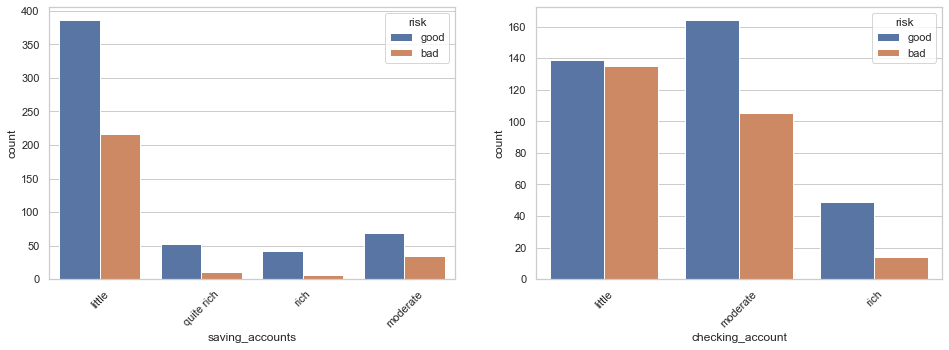

In [219]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
sns.countplot(x="saving_accounts", hue="risk", data=df, ax=ax1);
sns.countplot(x="checking_account", hue="risk", data=df, ax=ax2);
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
plt.show()

У людей с cheking account весьма много просрочек, чем cheking account больше, тем надежнее замщик. saving account - quite rich и rich - такие замщики более надежные.

<AxesSubplot:xlabel='sex', ylabel='age'>

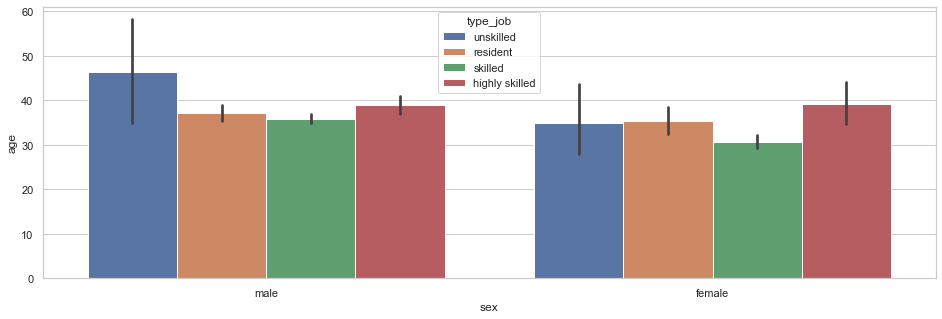

In [224]:
plt.figure(figsize=(16,5))
sns.barplot(data=df,x="sex",y="age",hue="type_job")

Вертикальные линии - доверительный интервалы. Здесь видим, что в общем то мужчины от женщин не отличаются, кроме того, что мужчины высококваллифицированы в интервале от 35-60 (среднее 47), а женщины - от 28 до 45 (среднее 33) - у мужчин больше интервал и среднее больше, высококвал. мужчины в среднем старше.

<AxesSubplot:xlabel='gap_age', ylabel='credit_amount'>

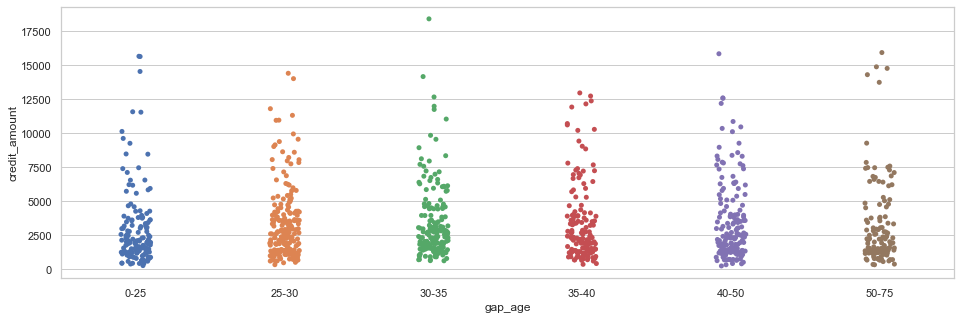

In [225]:
plt.figure(figsize = (16, 5))
sns.stripplot(x = "gap_age", y = "credit_amount", data = df)

Возраст слабо как то влияет на сумму кредита, по крайней мере визуально

C:\Anaconda\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Anaconda\lib\site-packages\seaborn\axisgrid.py:675: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


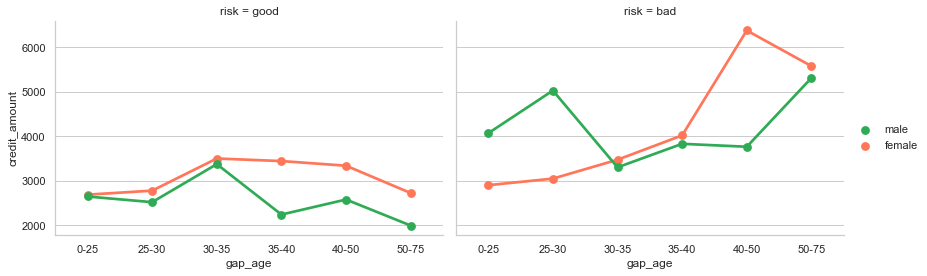

In [226]:
sns.FacetGrid(data=df,col="risk",aspect=1.5,height=4).map(sns.pointplot,"gap_age","credit_amount","sex",palette=["#FF7659","#30AB55"],ci=None).add_legend();

Люди с плохим риском берут большие суммы кредита, по крайней мере после 40 лет. Причем люди с хорошим риском, чем старше, тем берут меньшие суммы, а с плохим - чем старше, тем больше берут, вне зависимости от пола. 

### Корреляционная матрица

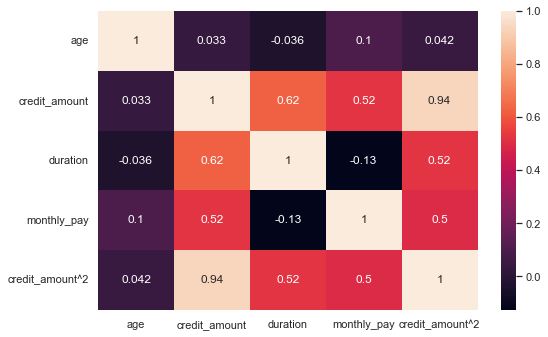

In [227]:
plt.figure(figsize=(8.5,5.5))
corr = sns.heatmap(df.corr(),xticklabels=df.corr().columns,yticklabels=df.corr().columns,annot=True)

Впринципе выводил в самом начале, но в виде фрейма. Здесь положительная зависимость между дюрацией и суммой кредита, что логично. Также чем выше сумма кредита, тем больше в месяц нужно платить, что также логично.

## Сохраним

In [229]:
df.to_csv("german_data_01.csv")